# Classical methods

## Overview
**Questions**
- How to classical potential models work?
- How do I get the parameters for a potential?

**Objectives**
- Introduce classical molecular dynamics
- Show examples of functions used to model non-bonded interactions
- Emphasize the requirement to use or develop accurate potential models for the system under study.

Classical methods is the phrase used to describe all methods that use a force-field (you may hear the term potential model) to model chemical systems. 
These can be molecular dynamics, Monte Carlo, Langevin dynamics, etc. 
However, we will focus on the application in MD.
These methods are distinct from quantum mechanical methods, such as density functional theory (DFT). 
In classical methods, the quantum mechanical **weirdness** is not present, which has a significant impact on the calculation efficiency. 
The need for quantum mechanics is removed by integrating over all of the electronic orbitals and motions, and describing the atom with a **fixed electron distribution**. 
This **simplification** has some drawbacks, these are only suitable for the study of the molecular ground states, limiting the ability to study reactions. 
Futhermore, it is necessary to **describe** this electron distribution. 

## Force-fields

In practice, the model used to describe the electron distribution is usually **isotropic**, e.g. a sphere, with the electron sharing bonds between the atoms described as springs (*Figure 1*). 
The aim of a lot of chemistry/physics is to understand the **energy** of the given system, therefore it is necessary to **parameterise** out models. 
For a molecular system, the energy is defined in terms of bonded and non-bonded interactions, 

$$ E_{\text{tot}} = E_{\text{bond}} + E_{\text{angle}} + E_{\text{dihedral}} + E_{\text{non-bond}} $$

where, $E_{\text{bond}}$, $E_{\text{angle}}$, and $E_{\text{dihedral}}$ are the energies associated with all of the bonded interactions, and $E_{\text{non-bond}}$ is the energy associated with all the of the non-bonded interactions. 
This tutorial will focus **only** on the non-bonded interactions.
However, all of the parameterisation of the non-bonded interactions must also be done for bonded interactions.
<center>
    <br>
    <img src="./images/fig001.png" width="400px">
    <i>Figure 1. A pictorial example of the models used in a classical method.</i>
    <br>
</center>

The parameterisation of this force-field involves the use of **mathematical functions** to described some physical relationship. 
For example, one of the two common non-bonded interactions is the electrostatic interaction between two charged particles, to model this interaction we use **Coulomb's law**, which was first defined in 1785, 

$$ E_{\text{Coulomb}}(r_{ij}) = \frac{1}{4\pi\epsilon_0}\frac{q_iq_je^2}{r_{ij}}, $$ 

where, $q_i$ and $q_j$ are the charges on the particles, $e$ is the charge of the electron, $\epsilon$ is the dielectric permitivity of vacuum, and $r_{ij}$ is the distance between the two particles. 

The python code below defines a function that models the electrostatic interaction using Coulomb's law and plots it.

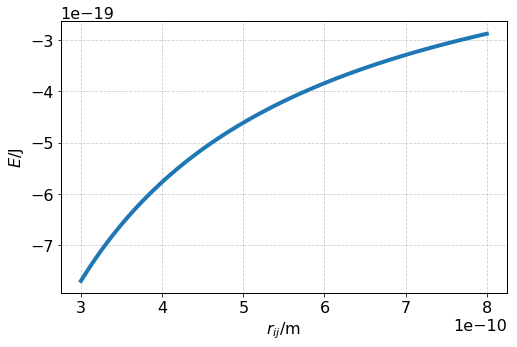

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import plot_style
from scipy.constants import e, epsilon_0

def coulomb(qi, qj, rij):
    """
    Calculation of Coulomb's law.
    
    Parameters
    ----------
    qi: float
        Charge on particle i
    qj: float
        Charge on particle j
    rij: float 
        Distance between two particles
        
    Returns
    -------
    float
        Energy of the Coulombic interaction
    """
    return 1 / (4 * np.pi * epsilon_0) * (qi * qj * e ** 2) / rij

r = np.linspace(3e-10, 8e-10, 100)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(r, coulomb(1, -1, r))
ax.set_xlabel(r'$r_{ij}$/m')
ax.set_ylabel(r'$E$/J')
plt.show()

The above cell can be thought of as the interaction between a sodium ion (Na<sup>+</sup>) and a chloride ion (Cl<sup>-</sup>).
These ions have opposite charges and therefore will be very strongly attracted to each other.
From this, it is clear that this mathematical function has clear roots in the **chemistry of the system**. 
Additionally, consider for a partially charged atom, such as the oxygen atom of a carbonyl functional group. 
This lacks a formal charge, therefore it is necessary to determine the appropriate value for $q$ for this atom.

The mathematical function for the non-bonded component of the interaction is less well defined. 
This is the **van der Waals** interaction, which encompasses both the attractive London dispersion effects and the repulsive Pauli exclusion principle. 
There are a variety of ways tthat the van der Waals interaction can be modelled. 

One commonly applied model is the **Lennard-Jones** potential model, which considers the attractve London dispersion effects as follows, 

$ E_{\text{attractive}}(r_{ij}) = \dfrac{-B}{r_{ij}^6},$ 

where $B$ is some constant for the interaction, and $r_{ij}$ is the distance between the two atoms. The Pauli exclusion principle is repulsive and only present over very short distances, and is therefore modelled with the relation, 

$ E_{\text{repulsive}}(r_{ij}) = \dfrac{A}{r_{ij}^{12}},$

The python code below defines each of the interaction energies associated with the Lennard-Jones potential, and the total van der Waals interaction.
These are then all plotted on a single graph. 
The values of $A$ and $B$ are those associated with an argon-argon interaction, as defined by Rahman [[5]](#Refences).

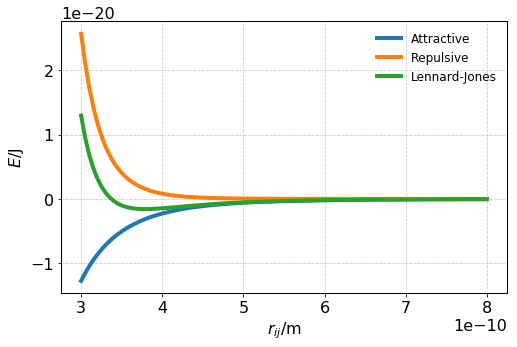

In [2]:
def attractive(rij, b):
    """
    Attractive component of the Lennard-Jones interaction.
    
    Parameters
    ----------
    rij: float
        Distance between two particles
    b: float 
        B parameter for interaction
    
    Returns
    -------
    float
        Energy of attractive component of Lennard-Jones 
        interaction
    """
    return -b / np.power(rij, 6)

def repulsive(rij, a):
    """
    Repulsive component of the Lennard-Jones interaction.
    
    Parameters
    ----------
    rij: float
        Distance between two particles
    a: float 
        A parameter for interaction
    
    Returns
    -------
    float
        Energy of repulsive component of Lennard-Jones 
        interaction
    """
    return a / np.power(rij, 12)

def lj(rij, a, b):
    """
    Implementation of the Lennard-Jones potential 
    to calculate the energy of the interaction.
    
    Parameters
    ----------
    rij: float
        Distance between two particles
    a: float 
        A parameter for interaction
    b: float 
        B parameter for interaction
    
    Returns
    -------
    float
        Energy of the interaction.
    """
    return repulsive(rij, a) + attractive(rij, b)

r = np.linspace(3e-10, 8e-10, 100)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(r, attractive(r, 9.273e-78), label='Attractive')
ax.plot(r, repulsive(r, 1.363e-134), label='Repulsive')
ax.plot(r, lj(r, 1.363e-134, 9.273e-78), label='Lennard-Jones')
ax.set_xlabel(r'$r_{ij}$/m')
ax.set_ylabel(r'$E$/J')
ax.legend(frameon=False)
plt.show()

The Lennard-Jones potential is not the only way to model the van der Waals interaction. 
Another commonly applied potential model is the **Buckingham** potential.
Similar to the Lennard-Jones potential, the Buckingham models the attractive term with a power-6. 
However, instead of the power-12 repulsion, this is modellsed with an exponential function. The total Buckingham potential has the following form, 

$ E_{\text{Buckingham}}(r_{ij}) = A\exp{-Br_{ij}} - \dfrac{C}{r_{ij}^6}, $

where $A$, $B$, and $C$ are interaction specific parameters that must be determined. 
N.B. these are not the same $A$ and $B$ as in the Lennard-Jones potential. 

The code below allows the comparison between these two potentials for modelling the van der Waals interaction, using defined parameters for the argon-argon interaction [[5,6]](#References)

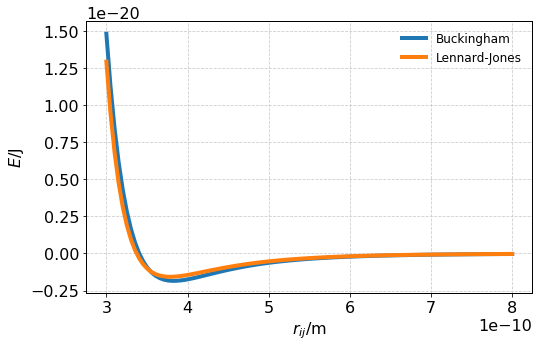

In [3]:
def buckingham(rij, a, b, c):
    """
    Implementation of the Buckingham potential 
    to calculate the energy of the interaction.
    
    Parameters
    ----------
    rij: float
        Distance between two particles
    a: float 
        A parameter for interaction
    b: float 
        B parameter for interaction
    c: float 
        C parameter for interaction
    
    Returns
    -------
    float
        Energy of the interaction.
    """
    return a * np.exp(-b * rij) - c / np.power(rij, 6)

r = np.linspace(3e-10, 8e-10, 100)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(r, buckingham(r, 1.69e-15, 3.66e10, 1.02e-77), 
        label='Buckingham')
ax.plot(r, lj(r, 1.363e-134, 9.273e-78), 
        label='Lennard-Jones')
ax.set_xlabel(r'$r_{ij}$/m')
ax.set_ylabel(r'$E$/J')
ax.legend(frameon=False)
plt.show()

There is a small but clear difference between the interaction energies for each potential. 
Now, keep in mind that these are just two of many potential models for the modelling of the Lennard-Jones interaction.
Furthermore, the parameters used in the model are just one example of the many possible parameterisations of the interaction. 

## Parameterisaton

## Key points
- Classical methods simplify the atomistic modelling by treating the atoms using mathematical functions
- There are a wide range of different mathematical functions available
- These **must** be well parameterised to accurately model the system at hand

# References

5. A. Rahman, (1964). Phys. Rev., 136, A405. [https://doi.org/10.1103/PhysRev.136.A405](10.1103/PhysRev.136.A405)
6. R. A. Buckingham, (1938). Proc. Royal Soc. Lond. A, 168, 264-283. [https://doi.org/10.1098/rspa.1938.0173](10.1098/rspa.1938.0173) 